Идея проекта: собрать данные парсингом с https://news.yahoo.co.jp/ - новости про Россию.

In [288]:
import re
import csv
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
import os
import time
from time import sleep
import random
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import spacy
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import matplotlib
import japanize_matplotlib # японский вариант Matplotlib
import matplotlib.pyplot as plt
from collections import Counter

# Шаг 1. Сбор ссылок с первой страницы поиска в новостной ленте

Построение запроса в поисковой строке агрегатора новостей

In [2]:
query = 'https://news.yahoo.co.jp/search?p={}'
url = query.format('ロシア')
browser = webdriver.Chrome()

Функция для сбора ссылок со страницы поискового запроса

In [2]:
def fetch_data_until_error(query, save_every):
    url = query.format('ロシア') # запрос по ключевому слову "Россия"
    browser.get(url)
    progress_bar = tqdm(desc="Fetching data", unit="clicks") # показывает прогресс

    while True:
        try:
            button_more = browser.find_element(By.XPATH,'//*[@id="contentsWrap"]/div/div[3]/div/div/span').click() # кликает на кнопку "Далее" (もっと見る)
            sleep_duration = random.uniform(1, 10)
            time.sleep(sleep_duration)     
            progress_bar.update(1)  # обновляется прогресс после каждого клика (примерно 50 статей)
        except NoSuchElementException:
            break  # окончание цикла кликания, если кнопки "Далее" на странице уже нет
            
    source = browser.page_source
    soup = BeautifulSoup(source, features="html.parser") # сбор данных со страницы

    # поиск ссылок
    links = soup.find_all('a')
    extracted_urls = [link.get('href') for link in links if link.get('href') is not None]
    extracted_urls = list(set(extracted_urls)) 
        
    # выделение ссылок на статьи "https://news.yahoo.co.jp/articles"
    legit_urls = [url for url in extracted_urls if "https://news.yahoo.co.jp/articles" in url]
        
    # исключение ссылок на статьи, состоящие из фотографии с подписью ('images')
    legit_urls = [i for i in legit_urls if not re.search('images', i)]
    
    save_to_csv(legit_urls)
    progress_bar.close()  # прекращение прогресса
    return legit_urls
    
# сохранение ссылок в отдельный файл
def save_to_csv(urls):
    filename = f"urls.csv"
    df = pd.DataFrame({"URLs": urls})
    df.to_csv(filename, index=False)

In [6]:
query = 'https://news.yahoo.co.jp/search?p={}'
urls = fetch_data_until_error(query, save_every=1) 

Fetching data: 19clicks [01:47,  5.67s/clicks]


Создание переменной для сбора данных по ссылкам

In [ ]:
df_urls = pd.read_csv('urls.csv')
urls_to_scrape = df_urls.URLs.values

# Шаг № 2. Сбор данных по каждой ссылке 

# Функция для парсинга текста статей

In [3]:
def GetData(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    title = soup.find_all('header')[-1].find_all('h1', {'class': 'sc-fnlXEO cudMNs'})[0].text.strip() # заголовок статьи
    time = soup.find_all(('time'))[0].text.strip() # дата статьи
    text = soup.find_all('p', {'class' : 'sc-cTkOCJ kaabur yjSlinkDirectlink highLightSearchTarget'}) # текст статьи
    text_list = [i.text for i in text]
    final_text = ' '.join(text_list)
    final_text = final_text.replace('\u3000', ' ') # очистка текста
    return url, title, time, final_text

Применение функции и сохранение данных в список

In [201]:
articles = []

for url in tqdm(urls_to_scrape, desc="Scraping URLs"):
    new = GetData(url)
    articles.append(new)

Scraping URLs: 100%|███████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]


Сбор всех данных в один файл

In [194]:
df = pd.DataFrame(articles)
df.head()
df.columns = ['link', 'title', 'time', 'text']

In [195]:
df.head(2)

,link,title,time,text
0,https://news.yahoo.co.jp/articles/6733c3e3dc8d...,スウェーデンのＮＡＴＯ加盟、トルコが承認…残るはハンガリーのみ,1/24(水) 14:20,【カイロ＝田尾茂樹、ロンドン＝蒔田一彦】トルコ議会は２３日の本会議で、北欧スウェーデンの北...
1,https://news.yahoo.co.jp/articles/14b4f1508213...,ウォール・ストリート・ジャーナル記者の勾留期間、2か月延長へ 身柄の拘束1年に ロシア,1/26(金) 20:16,ロシアでスパイ罪で起訴されたウォール・ストリート・ジャーナルの記者について、モスクワの裁判所...


In [ ]:
Сохранение данных в xlsx-файл

In [197]:
df.to_excel('full_yahoo_news.xlsx')

# Шаг № 3. Обработка полученных данных

In [2]:
print(os.getcwd())

C:\Users\Idril\Документы\CL\Project 1


In [3]:
os.chdir('C:\\Users\\Idril\\Документы\\CL\\Project 1\\Собранные материалы\\Статьи')

In [4]:
news_file = 'full_yahoo_news.xlsx'
df_news = pd.read_excel(news_file)
try:
    df_news = df_news.drop(columns='Unnamed: 0')
except:
    pass

In [7]:
print(df_news.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   link    1068 non-null   object
 1   title   1063 non-null   object
 2   time    1068 non-null   object
 3   text    1068 non-null   object
dtypes: object(4)
memory usage: 33.5+ KB
None


## Функции для обработки текста

Загрузка японской модели SpaCy

In [5]:
nlp = spacy.load('ja_core_news_lg')

### Токенизация

Проверка списка стоп-слов в Spacy

In [6]:
stopwords = spacy.lang.ja.stop_words.STOP_WORDS
print(stopwords)

{'にて', 'たら', 'ところ', 'ほとんど', 'かつ', 'よ', 'はじめ', '一', 'お', 'あ', 'よく', 'おり', 'る', 'ほぼ', 'あっ', 'また', 'あれ', 'か', 'ば', 'やっ', 'できる', 'だっ', 'かつて', 'は', 'まま', 'ひと', 'て', 'のち', 'から', 'ち', 'など', 'こう', 'さん', 'さ', 'しかし', 'よっ', 'ここ', 'もと', 'その', 'ただし', 'つけ', 'た', 'そう', 'しか', 'なかっ', 'とも', 'いう', 'ため', 'を', 'べき', 'いく', 'これ', 'ない', 'より', 'なり', 'でき', 'のみ', 'なお', 'ほど', 'いずれ', 'れる', 'たり', 'や', 'なく', 'こと', 'ごと', 'ぬ', 'なる', 'と', 'な', 'せい', 'いつ', 'そして', 'だけ', 'もっ', 'かけ', 'かなり', 'られる', 'おけ', 'い', 'つ', 'つつ', 'られ', 'で', 'こ', 'とき', 'ぶり', 'せる', 'だ', 'ず', 'そこ', 'それ', 'なし', 'よる', 'ご', 'れ', 'きっかけ', 'いっ', 'らしい', 'うち', 'も', 'ん', 'し', 'しよう', 'とっ', 'ある', 'つい', 'それぞれ', 'み', 'さらに', 'ながら', 'いわ', 'の', 'ちゃん', 'すぐ', 'ほか', 'ます', 'おら', 'き', 'しまっ', 'す', 'え', 'いい', 'どう', 'する', 'よれ', 'たち', 'よう', 'たい', 'へ', 'いる', 'あり', 'に', 'まで', 'おい', 'すべて', 'くる', 'くん', 'なっ', 'もう', 'ま', 'および', 'なけれ', 'もの', 'です', 'あまり', 'なら', 'この', 'あるいは', 'ら', 'しまう', 'が', 'ね', 'せ'}


Токенизация и предобработка текста (удаление пунктуации и стоп-слов)

In [10]:
def tokenize(text):
    stopwords = spacy.lang.ja.stop_words.STOP_WORDS
    regex = re.compile(r'[］［!()\（\）「」、\-!！\[\];:+,<>./?@#$%^&*_~。…・，【】？]') # список японских знаков пунктуации
    doc = nlp(text)
    tokens = []
    for token in doc:
        word = token.text
        if word == ' ' or '\n' in word:
            continue
        tokens.append(word)
    filtered_tokens = [token for token in tokens if token not in stopwords]
    filtered_tokens = [token for token in filtered_tokens if not regex.search(token)]
    return filtered_tokens

In [11]:
df_news['Tokenized_Text'] = df_news.text.apply(tokenize) # добавление столбца с токенизированным текстом

In [98]:
df_news['Tokenized_Text'][0][:10]

['モスクワ', '２４', '日', 'ロイター', 'ロシア', '国防', '省', '捕虜', 'ウクライナ', '兵士']

Сохранение данных в формат xlsx

In [12]:
df_news.to_excel('full_yahoo_news_tokenized.xlsx', index=False)

### Лемматизация и частеречная разметка

In [7]:
articles_file = 'full_yahoo_news_tokenized.xlsx'
df = pd.read_excel(articles_file)

In [47]:
# создание корпуса обработанных токенов

columns = ["Text", "Lemma", "Morphology", "POS", "Dependency", "Head_text", "Head_POS"]

data = []
for text in df.Tokenized_Text:
    text = re.sub(r'[\'(\[)(\])\,]', '', text)
    doc = nlp(text)
    for token in doc:
        parsed = [token.text, token.lemma_, token.morph, token.pos_, token.dep_, token.head.text, token.head.pos_]
        data.append(parsed)

new_data = pd.DataFrame(np.array(data), columns=columns)
new_data

,Text,Lemma,Morphology,POS,Dependency,Head_text,Head_POS
0,モスクワ,モスクワ,(Reading=モスクワ),PROPN,compound,日,NOUN
1,２４,24,(Reading=ニヨン),NUM,dislocated,日,NOUN
2,日,日,(Reading=ヒ),NOUN,nmod,日,NOUN
3,ロイター,ロイター,(Reading=ロイター),PROPN,compound,日,NOUN
4,ロシア,ロシア,(Reading=ロシア),PROPN,compound,日,NOUN
...,...,...,...,...,...,...,...
244635,月,月,(Reading=ツキ),NOUN,nmod,News,NOUN
244636,撮影,撮影,(Reading=サツエイ),NOUN,compound,News,NOUN
244637,c,c,(Reading=c),NOUN,compound,News,NOUN
244638,AFPBB,afpbb,(Reading=afpbb),NOUN,compound,News,NOUN


In [48]:
new_data.to_excel("articles_pos_data.xlsx", index=False) # сохранение полученных данных в отдельный файл

## Анализ полученного корпуса

### Количество и доля частей речи в корпусе

In [14]:
corpus = pd.read_excel('articles_pos_data.xlsx')

In [50]:
def pos_counter(datafr, column):
    adj_num = corpus['POS'].value_counts()['ADJ']
    adp_num = corpus['POS'].value_counts()['ADP']
    adv_num = corpus['POS'].value_counts()['ADV']
    aux_num = corpus['POS'].value_counts()['AUX'] 
    cconj_num = corpus['POS'].value_counts()['CCONJ']
    det_num = corpus['POS'].value_counts()['DET']
    intj_num = corpus['POS'].value_counts()['INTJ']
    noun_num = corpus['POS'].value_counts()['NOUN']
    num_num = corpus['POS'].value_counts()['NUM']
    part_num = corpus['POS'].value_counts()['PART']
    pron_num = corpus['POS'].value_counts()['PRON']
    propn_num = corpus['POS'].value_counts()['PROPN']
    punct_num = corpus['POS'].value_counts()['PUNCT']
    sconj_num = corpus['POS'].value_counts()['SCONJ']
    space_num = corpus['POS'].value_counts()['SPACE']
    verb_num = corpus['POS'].value_counts()['VERB']
    x_num = corpus['POS'].value_counts()['X']
    return adj_num, adp_num, adv_num, aux_num, cconj_num, det_num, \
    intj_num, noun_num, num_num, part_num, pron_num, propn_num, punct_num, sconj_num, space_num, verb_num, x_num

In [51]:
pos_num = pd.DataFrame(corpus['POS'].value_counts())

In [52]:
pos_num = pos_num.rename(columns={0:'POS', 'count':'Number'})

In [53]:
pos_num = pos_num.reset_index()

In [54]:
len(corpus)

244640

In [55]:
pos_num['Share'] = pos_num['Number'] / int(len(corpus))

In [56]:
pos_num

,POS,Number,Share
0,NOUN,166894,0.682202
1,PROPN,28155,0.115087
2,NUM,17058,0.069727
3,VERB,13136,0.053695
4,ADJ,6044,0.024706
5,ADV,4580,0.018721
6,PUNCT,1663,0.006798
7,AUX,1584,0.006475
8,PART,1546,0.006319
9,ADP,1259,0.005146


In [57]:
pos_num.to_excel("pos_values.xlsx", index=False)

In [58]:
# сохранение данных в виде png-изображения
import dataframe_image as dfi
dfi.export(pos_num, 'dataframe final.png')

## Выведение самых частотных слов

Удаление из корпуса числительных и пунктуации

In [192]:
df = corpus.drop(corpus[corpus['POS'] == 'NUM'].index)
df = df.drop(corpus[corpus['POS'] == 'PUNCT'].index)
df

,Text,Lemma,Morphology,POS,Dependency,Head_text,Head_POS
0,モスクワ,モスクワ,Reading=モスクワ,PROPN,compound,日,NOUN
2,日,日,Reading=ヒ,NOUN,nmod,日,NOUN
3,ロイター,ロイター,Reading=ロイター,PROPN,compound,日,NOUN
4,ロシア,ロシア,Reading=ロシア,PROPN,compound,日,NOUN
5,国防,国防,Reading=コクボウ,NOUN,compound,日,NOUN
...,...,...,...,...,...,...,...
244635,月,月,Reading=ツキ,NOUN,nmod,News,NOUN
244636,撮影,撮影,Reading=サツエイ,NOUN,compound,News,NOUN
244637,c,c,Reading=c,NOUN,compound,News,NOUN
244638,AFPBB,afpbb,Reading=afpbb,NOUN,compound,News,NOUN


Выведение самых частотных 30 слов

In [92]:
frequency = nltk.FreqDist(df['Text'])
check_num = 30
print(frequency.most_common(check_num))

[('ロシア', 2888), ('年', 2487), ('日', 2238), ('ウクライナ', 2179), ('月', 1593), ('人', 1404), ('的', 1347), ('日本', 1291), ('氏', 1001), ('者', 881), ('まし', 860), ('大統領', 788), ('第', 749), ('中', 686), ('軍', 654), ('世界', 620), ('中国', 593), ('国', 591), ('位', 589), ('戦', 568), ('米国', 558), ('選手', 555), ('機', 543), ('攻撃', 532), ('北朝鮮', 532), ('性', 528), ('受け', 479), ('代表', 478), ('後', 475), ('大会', 475)]


Создание и сохранения графика распределения частотности слов

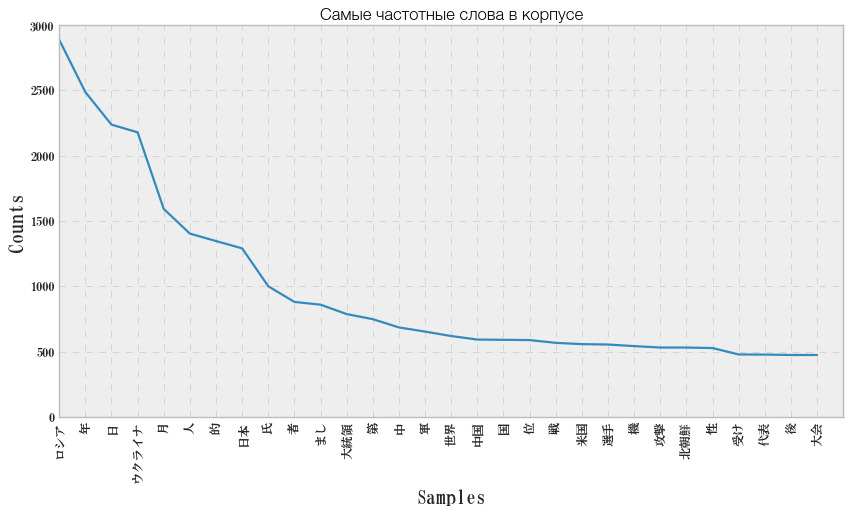

In [162]:
matplotlib.rcParams['font.family'] = ['HGMinchoE'] # японский шрифт
matplotlib.rcParams.update({'font.size': 15})
plt.style.use('bmh')
plt.figure(figsize = (10,5))
plt.title('Самые частотные слова в корпусе', font='Helvetica', fontsize=15, color='black', fontstyle='italic')
frequency = nltk.FreqDist(df['Text'])
frequency.plot(30, show=False)
plt.savefig('Most_frequent_words30.png', bbox_inches='tight') # сохранение графика в png-файл
plt.show()

## Создание облака слов

In [228]:
def make_word_cloud(text):
  font_path = 'NotoSansCJKjp-VF.otf' # использование японского шрифта, файл необходимо установить в рабочую папку
  wordcloud = WordCloud(width=1500,
                        height=1000,
                        max_words=900,
                        colormap='PuRd_r',
                        background_color="skyblue",
                        font_path = font_path,
                        normalize_plurals=True).generate_from_frequencies(text)
  # setup a plot frame without any axis and print the image generated above  
  plt.figure(figsize=(17,14))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.savefig('Worlcloud.png', bbox_inches='tight') # сохранение построенного облака в отдельный файл
  plt.show()

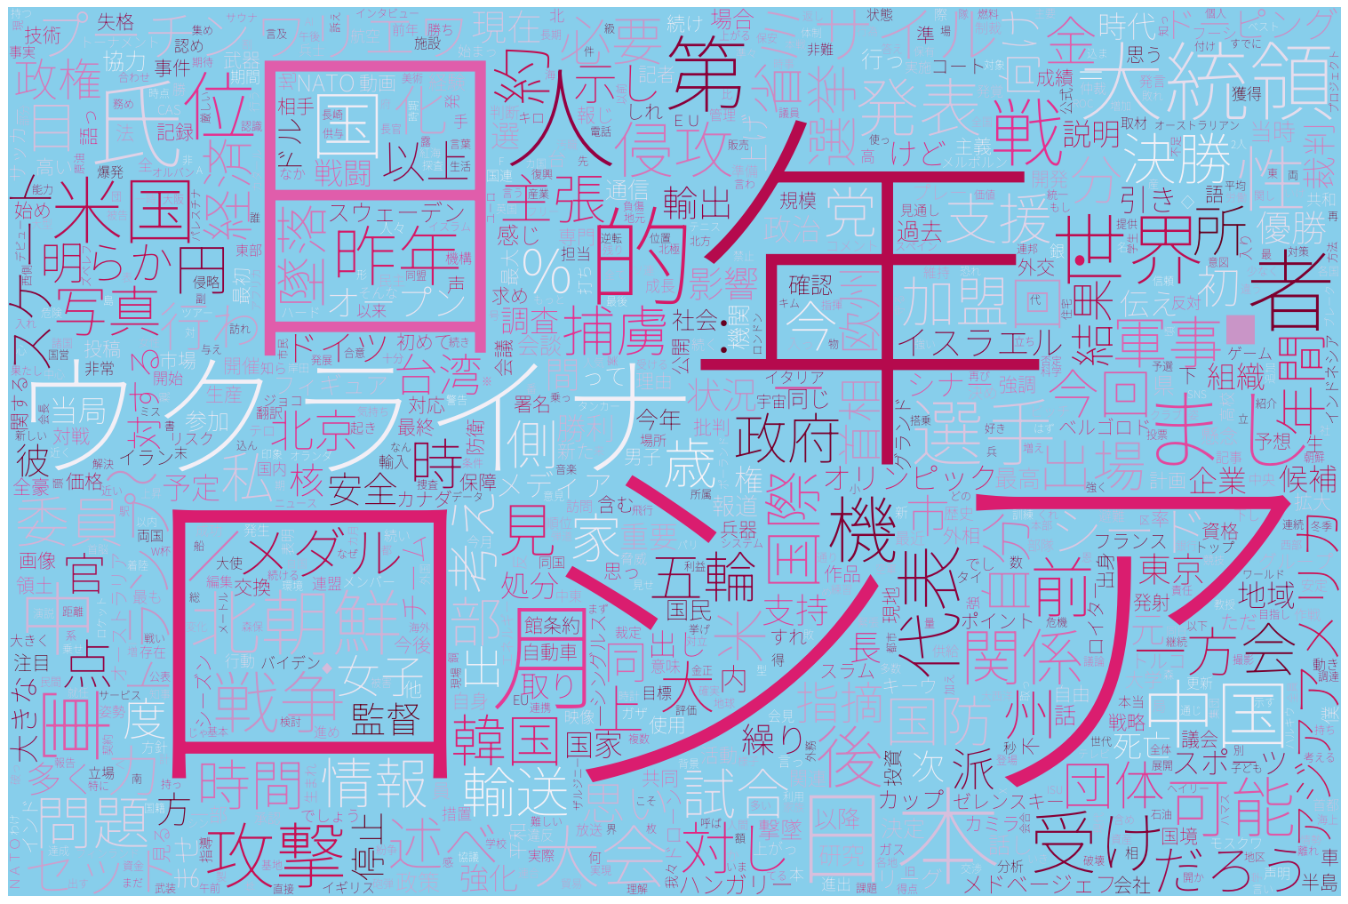

In [229]:
make_word_cloud(frequency)

## Поиск и выведение самых распространенных именованных сущностей 

In [230]:
articles_file = 'full_yahoo_news_tokenized.xlsx'
df = pd.read_excel(articles_file)

In [235]:
columns = ['NER', 'TYPE']

ner_list = []
for text in df.text:
    doc = nlp(text)
    for ent in doc.ents:
        ner_data = [ent.text, ent.label_]
        ner_list.append(ner_data)

ner_data = pd.DataFrame(np.array(ner_list), columns=columns)
ner_data

,NER,TYPE
0,モスクワ ２４日,EVENT
1,ロイター,ORG
2,ロシア国防省,ORG
3,ウクライナ,GPE
4,６５人,QUANTITY
...,...,...
43873,アレクセイ・ナワリヌイ,PERSON
43874,Alexei Navalny,PRODUCT
43875,テレグラム,ORG
43876,ロシア軍,ORG


In [236]:
ner_data.to_excel("ner_data.xlsx", index=False)

Самые популярные личности (NER type = 'Person')

In [245]:
ner_person = ner_data.loc[ner_data['TYPE'] == 'PERSON']
ner_person

,NER,TYPE
17,ゼレンスキー,PERSON
40,ラブロフ,PERSON
56,アンドレイ・カルタポロフ,PERSON
90,小川美那,PERSON
100,小池,PERSON
...,...,...
43850,エリッヒ・マリア・レマルク,PERSON
43857,ドミトリー・シェストパロフ,PERSON
43861,アナスタシア・ルデンコ,PERSON
43862,Anastasya Rudenko,PERSON


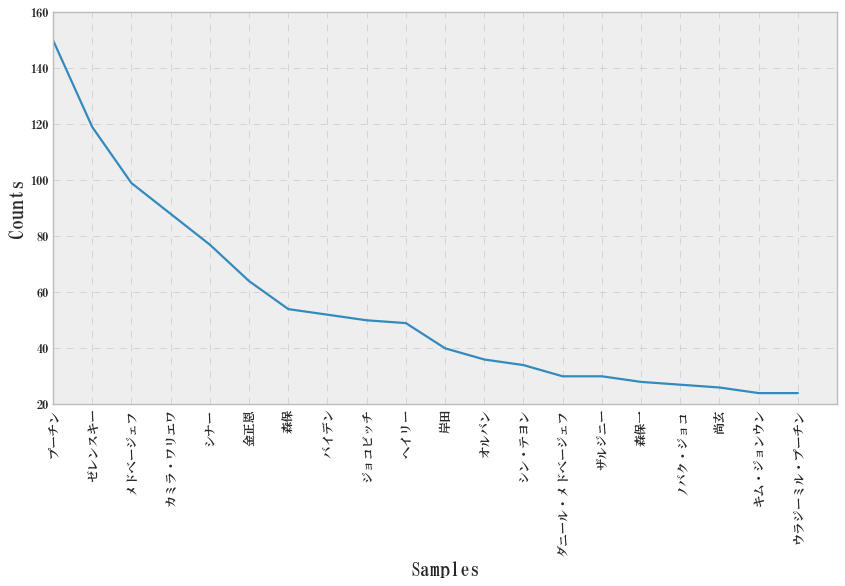

In [251]:
popular_person = nltk.FreqDist(ner_person['NER'])
plt.style.use('bmh')
plt.figure(figsize = (10,5))
popular_person.plot(20, show=False)
plt.savefig('Most_popular_persons.png', bbox_inches='tight') # сохранение графика в png-файл
plt.show()

In [ ]:
## Подсчет числа статей каждый день

Изменение формата данных и выведение графика

In [279]:
date = []
for elem in df.time:
    date_changed = ''.join(elem[0:4])
    date.append(date_changed)

In [283]:
from collections import Counter
number_by_date = Counter(date)

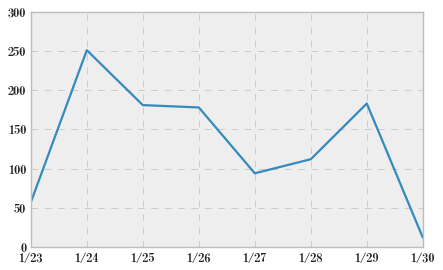

In [287]:
lists = sorted(number_by_date.items())
x, y = zip(*lists)
plt.figure(figsize = (5,3))
plt.plot(x, y)
plt.savefig('Articles_by_day.png', bbox_inches='tight')
plt.show()